<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


2021-09-03 04:41:05,571:INFO:Using device: cpu


## Data

In [3]:
from sklearn.datasets import load_digits
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, repeat

class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode: str='train', image: bool=True, transforms: bool=None):
        digits = load_digits()
        
        # change type
        digits = digits.astype(np.float32)
        
        # change shape
        if image:
            digits = rearrange(digits, "B (C W H) -> B C W H", C=1, H=8, W=8)
            
        if mode == 'train':
            self.data = digits.data[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350]
        else:
            self.data = digits.data[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [4]:
num_x = 4
num_y = 4
digits = load_digits()

data = digits.images#[:1000]

# fig, ax = plt.subplots(num_x, num_y)
# for i, ax in enumerate(ax.flatten()):
#     plottable_image = np.reshape(data[i], (8, 8))
#     ax.imshow(plottable_image, cmap='gray')
#     ax.axis('off')

In [5]:
def plot_digits(data, num_x, num_y):
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = data[i]
        
        if data.ndim == 2:
            plottable_image = np.reshape(plottable_image, (8, 8))
        
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    return None

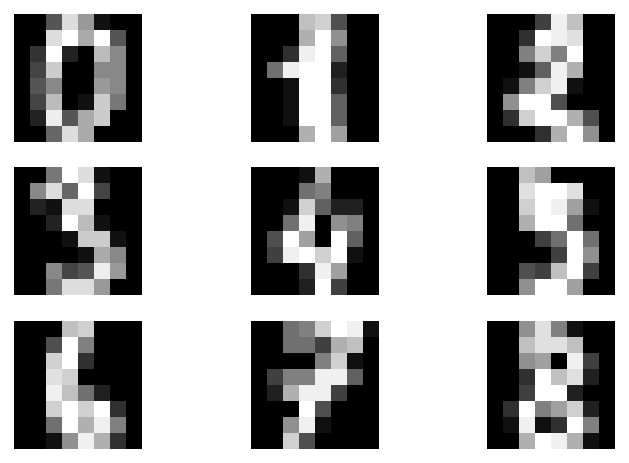

In [6]:
plot_digits(data, 3,3)

#### DataLoader

In [7]:
# from pl_bolts.datamodules import SklearnDataModule, SklearnDataset
from torchvision.transforms import Compose, ToTensor

# def unsqueeze_digit(x):
#     return rearrange(X_train, "B H W -> B C H W", C=1)


# # transformations
# transforms = Compose([
#     unsqueeze_digit,
#     ToTensor
# ])
# ds = SklearnDataset(data)

In [8]:
n_train = 5_000
n_valid = 1_000
data_init = digits.images[:100]
data_train = digits.images[:1000]
data_valid = digits.images[1000:1350]
data_test = digits.images[1350:]


X_init = torch.FloatTensor(data_init)
X_train = torch.FloatTensor(data_train)
X_valid = torch.FloatTensor(data_valid)
X_test = torch.FloatTensor(data_test)

# # reshape
# X_train = rearrange(X_train, "B (H W) -> B H W", H=8, W=8)
# X_valid = rearrange(X_valid, "B (H W) -> B H W", H=8, W=8)
# X_test = rearrange(X_test, "B (H W) -> B H W", H=8, W=8)

# repeat
X_init = repeat(X_init, "B H W -> B C H W", C=3,)
X_train = repeat(X_train, "B H W -> B C H W", C=3,)
X_valid = repeat(X_valid, "B H W -> B C H W", C=3, )
X_test = repeat(X_test, "B H W -> B C H W", C=3, )

# make into dataset
train_ds = TensorDataset(X_train)
valid_ds = TensorDataset(X_valid)
test_ds = TensorDataset(X_test)

# make dataloader
batch_size = 16
num_workers = 1
shuffle = True

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Model

### Lightning Module

In [9]:
from src.lit_plane import FlowLearnerPlane

In [10]:
import ml_collections

cfg = ml_collections.ConfigDict()
cfg.loss_fn = "inn"
cfg.num_epochs = 200
cfg.learning_rate = 1e-2
cfg.batch_size = 100
cfg.weight_decay = 0.0
cfg.beta1 = 0.9
cfg.beta2 = 0.999
cfg.betas = (cfg.beta1, cfg.beta2)


## Normalizing Flow Models

In [11]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.dequantization import UniformDequantization
from src.models.layers.convolutions import Conv1x1, Conv1x1Householder, ConvExponential

#### Coupling Network

In [12]:
# subset net
def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

### RealNVP Model

In [16]:
from src.models.layers.multiscale import SplitPrior

In [134]:
split_proportions = (1, X_init.shape[1] - 1)
split_proportions

(1, 2)

In [139]:
d = torch.zeros((3, 8, 8)).unsqueeze(0)
d.shape

torch.Size([1, 3, 8, 8])

In [81]:
prior = dist.Normal(0.0, 1.0)

inn = Ff.SequenceINN(4, 32, 32)

inn.append(
    SplitPrior,
    prior=prior
    
)
inn.append(
    Fm.RNVPCouplingBlock, 
    subnet_constructor=subnet_conv, 
)

[(4, 32, 32)]
(2, 32, 32)


In [82]:
demo_data = torch.zeros((1_000, 4, 32, 32))

z, log_jac_det = inn(demo_data)
print(z.shape)

torch.Size([1000, 2, 32, 32])


In [83]:
x_, log_jac_det = inn(z, rev=True)
print(x_.shape)

torch.Size([1000, 4, 32, 32])


#### Architecture

In [21]:
inn = Ff.SequenceINN(3, 8, 8)

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)

for ilayer in range(1):
    
    # COUPLING
    inn.append(
        Fm.RNVPCouplingBlock, 
        subnet_constructor=subnet_conv, 
    )

    # ACTNORM
    inn.append(
        Fm.ActNorm, 
    )
    
    # 1x1 CONVOLUTION
    inn.append(
        ConvExponential, 
    )
    
# UpSampling
inn.append(
    Fm.IRevNetUpsampling, 
)

#### Demo

torch.Size([100, 3, 8, 8])


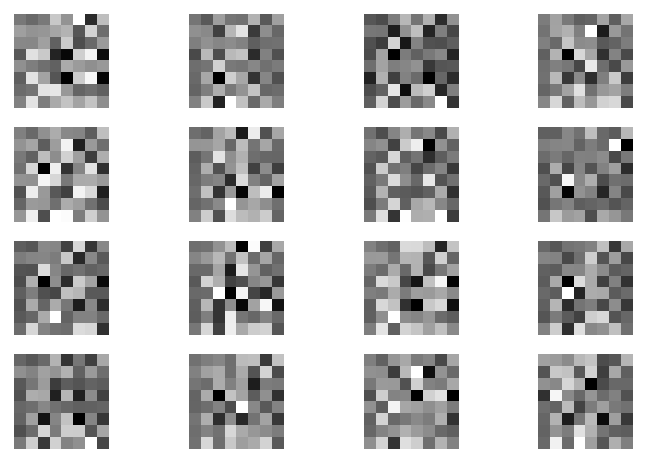

In [22]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

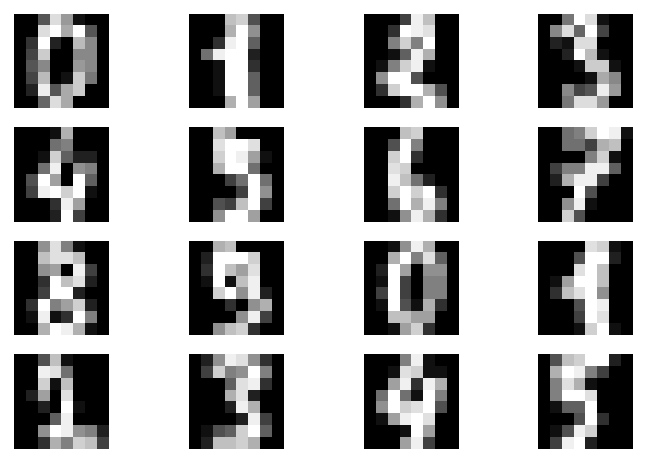

In [23]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

### GLOW Model

In [38]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)
print(inn(X_init)[0].shape)



torch.Size([100, 12, 4, 4])
torch.Size([100, 48, 2, 2])
torch.Size([100, 192, 1, 1])


#### Architecture

In [45]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)



# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)


for ilayer in range(1):
    
    # COUPLING
    inn.append(
        Fm.GLOWCouplingBlock, 
        subnet_constructor=subnet_conv, 
    )

    # ACTNORM
    inn.append(
        Fm.ActNorm, 
    )
    
    # 1x1 CONVOLUTION
    inn.append(
        ConvExponential, 
    )
    
# UpSampling
inn.append(
    Fm.IRevNetUpsampling, 
)

#### Demo

torch.Size([100, 3, 8, 8])


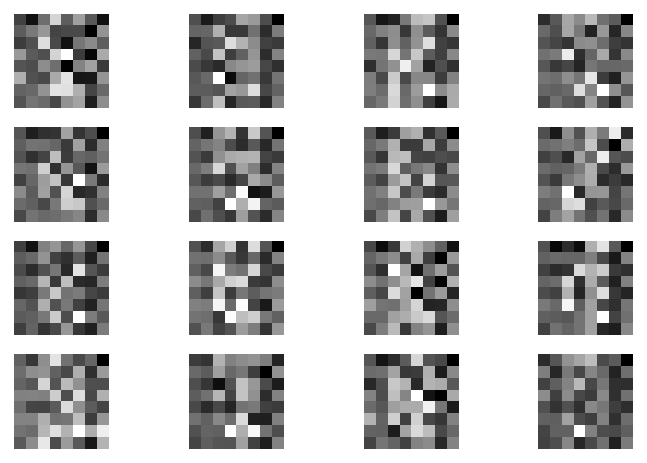

In [46]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

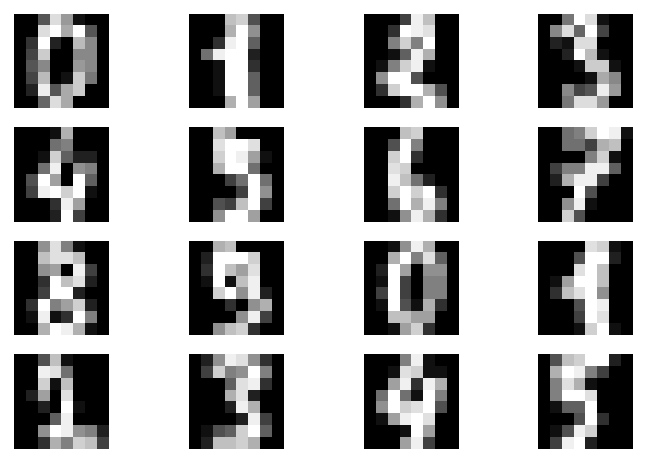

In [47]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

### Neural Spline Flows

In [31]:
from src.models.layers.coupling import get_coupling_layer
from src.models.nets.conv import ConvNet
from nflows.utils import create_mid_split_binary_mask


def nflows_covnet(dims_in, dims_out):
    return ConvNet(dims_in, 256, dims_out)

#### Architecture

In [32]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

# DownSampling (Easy CheckerBoard Mask)
inn.append(
    Fm.IRevNetDownsampling, 
)

# get new channels
n_channels_ = inn(X_init)[0].shape[1]

for ilayer in range(1):
    
    # COUPLING (NSF)
    coupling_transform = get_coupling_layer(coupling="rqs")
    
    mask = create_mid_split_binary_mask(features=n_channels_)
    
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_covnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )

    # ACTNORM
    inn.append(
        Fm.ActNorm, 
    )
    
    # 1x1 CONVOLUTION
    inn.append(
        Conv1x1, 
    )
    
# UpSampling
inn.append(
    Fm.IRevNetUpsampling, 
)

#### Demo

torch.Size([100, 3, 8, 8])


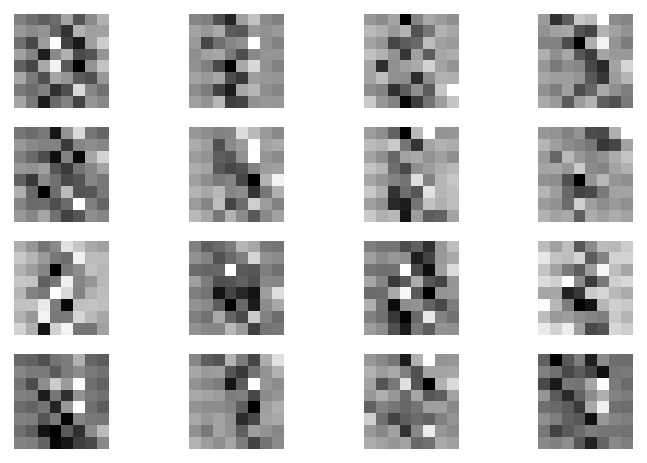

In [33]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

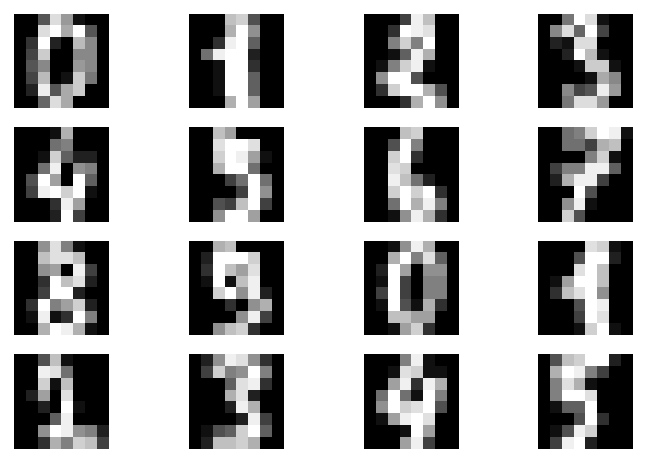

In [34]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

### Gaussianization Flows

In [42]:
from src.models.layers.mixtures import GaussianMixtureCDF
from src.models.layers.nonlinear import InverseGaussCDF

#### Initialization

In [120]:


def propagate(inn, init_X):
#     print("Before:", init_X.shape)
    with torch.no_grad():
        z, ldj = inn.module_list[-1]([init_X,])
    if isinstance(z, tuple):
        z = z[0]
#     print("After:", z.shape)
    return z

#### Architecture

In [121]:
X_init.shape

torch.Size([100, 3, 8, 8])

In [126]:
n_components=10

# for the initialization
init_X = X_init.detach().clone()

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)

total_n_features = 3 * 8 * 8


# uniform dequantization (for integers)
# print("Dequantization")
inn.append(
    UniformDequantization,
    num_bits=8
)
init_X = propagate(inn, init_X)


# DownSampling (Easy CheckerBoard Mask)
# print("DownSampling")
inn.append(
    Fm.IRevNetDownsampling, 
)
init_X = propagate(inn, init_X)
new_dims = init_X.shape[1:]


for ilayer in range(1):
    
    # FLATTEN
#     print("Flatten")
    inn.append(
        Fm.Flatten
    )
    init_X = propagate(inn, init_X)
    
    # ELEMENT-WISE NONLINEAR LAYER (CDF)
#     print("Mixture Gaussian CDF")
    inn.append(
        GaussianMixtureCDF,
        n_components=n_components,
        init_X=init_X,
    )
    
    init_X = propagate(inn, init_X)

    # INVERSE CDF
#     print("Inverse CDF")
    inn.append(InverseGaussCDF)
    init_X = propagate(inn, init_X)
    
    # UNFLATTEN
#     print("UnFlatten")
    inn.append(
        Fm.Reshape,
        output_dims=new_dims
    )
    init_X = propagate(inn, init_X)
    
    # 1x1 CONVOLUTION
#     print("1x1 Convolution")
    inn.append(
        Conv1x1Householder, 
    )
    init_X = propagate(inn, init_X)
    
# UpSampling
# print("UpSampling")
inn.append(
    Fm.IRevNetUpsampling, 
)


#### Demo

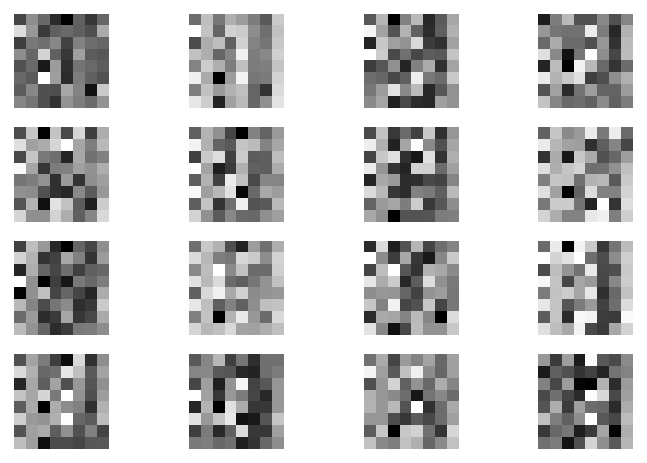

In [127]:
z, log_jac_det = inn(X_init)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

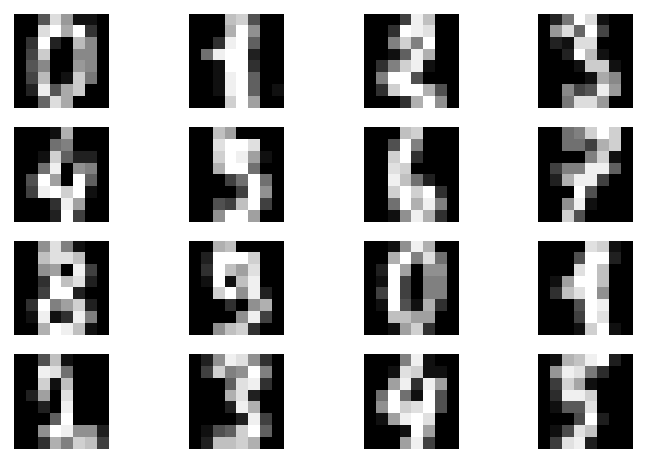

In [125]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori[:, 0, ...].detach().numpy(), 4, 4)

In [80]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

n_channels = 3
n_features = 3 * 64

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(3, 8, 8)
for ilayer in range(1):
    
#     # Glow Coupling
#     inn.append(
#         Fm.GLOWCouplingBlock, 
#         subnet_constructor=subnet_conv, 
#         )
    # NSF Coupling
    coupling_transform = get_coupling_layer(coupling="rqs")
    mask = create_mid_split_binary_mask(features=n_channels)
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_covnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )
    
    # Orthogonal Transform
    coupling_transform = get_coupling_layer(coupling="rqs")
    mask = create_mid_split_binary_mask(features=n_channels)
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_covnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )
    
#     # All-In-ONE-Block
#     inn.append(
#         Fm.AllInOneBlock, 
#         subnet_constructor=subnet_conv, 
#         permute_soft=False, 
#         gin_block=False, 
#         learned_householder_permutation=1
#         )
# inn.append(Fm.Flatten)
base_dist = dist.MultivariateNormal(torch.zeros(n_features), torch.eye(n_features))

#### Initial Transformation

torch.Size([100, 3, 8, 8])


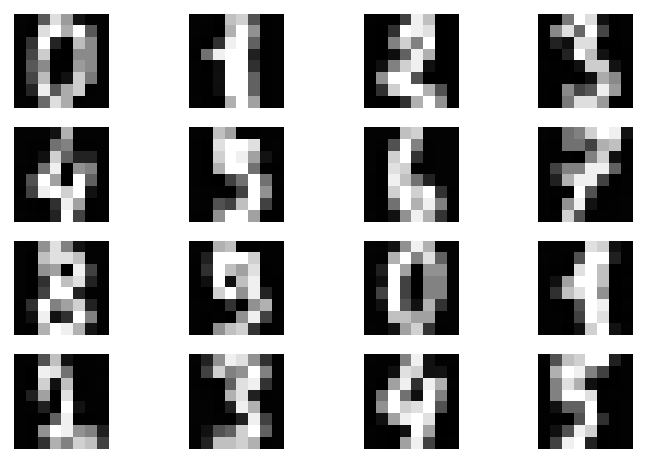

In [81]:
z, log_jac_det = inn(X_init)
print(z.shape)

plot_digits(z[:, 0, ...].detach().numpy(), 4, 4)

In [33]:
z.shape, X_init.shape

(torch.Size([100, 3, 8, 8]), torch.Size([100, 3, 8, 8]))

#### Inverse Transformation

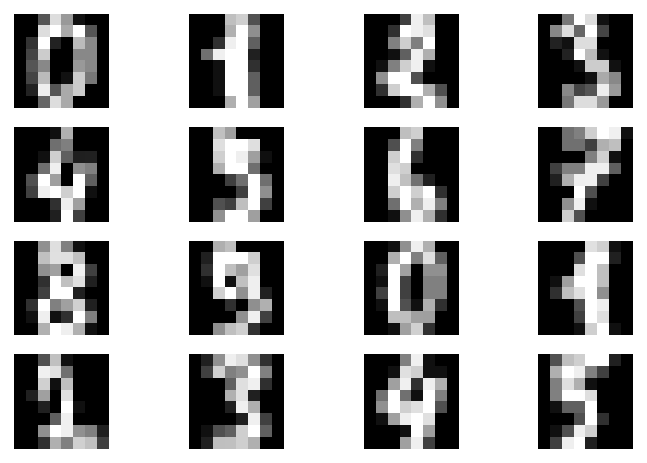

In [24]:
x_ori, _ = inn(z, rev=True)

plot_digits(x_ori.detach().numpy(), 4, 4)

## Training

In [25]:
%%time

learn = FlowLearnerPlane(inn,  base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 464 K 
--------------------------------------
398 K     Trainable params
65.5 K    Non-trainable params
464 K     Total params
1.858     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CPU times: user 1h 52min 59s, sys: 36.9 s, total: 1h 53min 35s
Wall time: 7min 4s


#### Latent Space

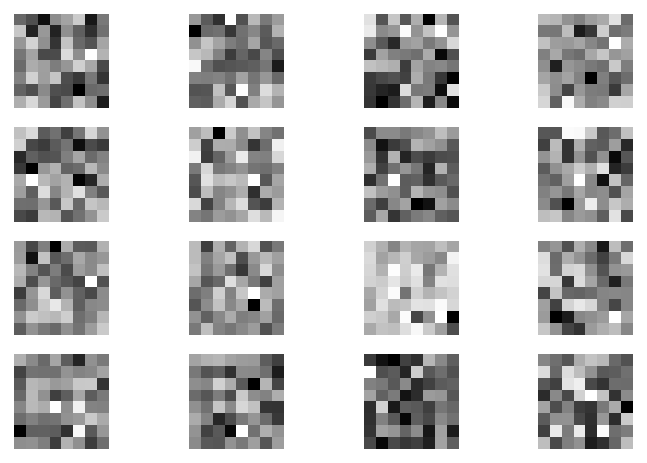

In [26]:
x = torch.Tensor(data_init)
z, log_jac_det = learn.model(x)

plot_digits(z.detach().numpy(), 4, 4)

2021-06-27 20:52:09,091:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,123:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,144:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,173:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,194:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,215:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,246:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,267:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,288:WARNING:Too few points to create valid contours
2021-06-27 20:52:09,310:WARNING:Too few points to create valid contours


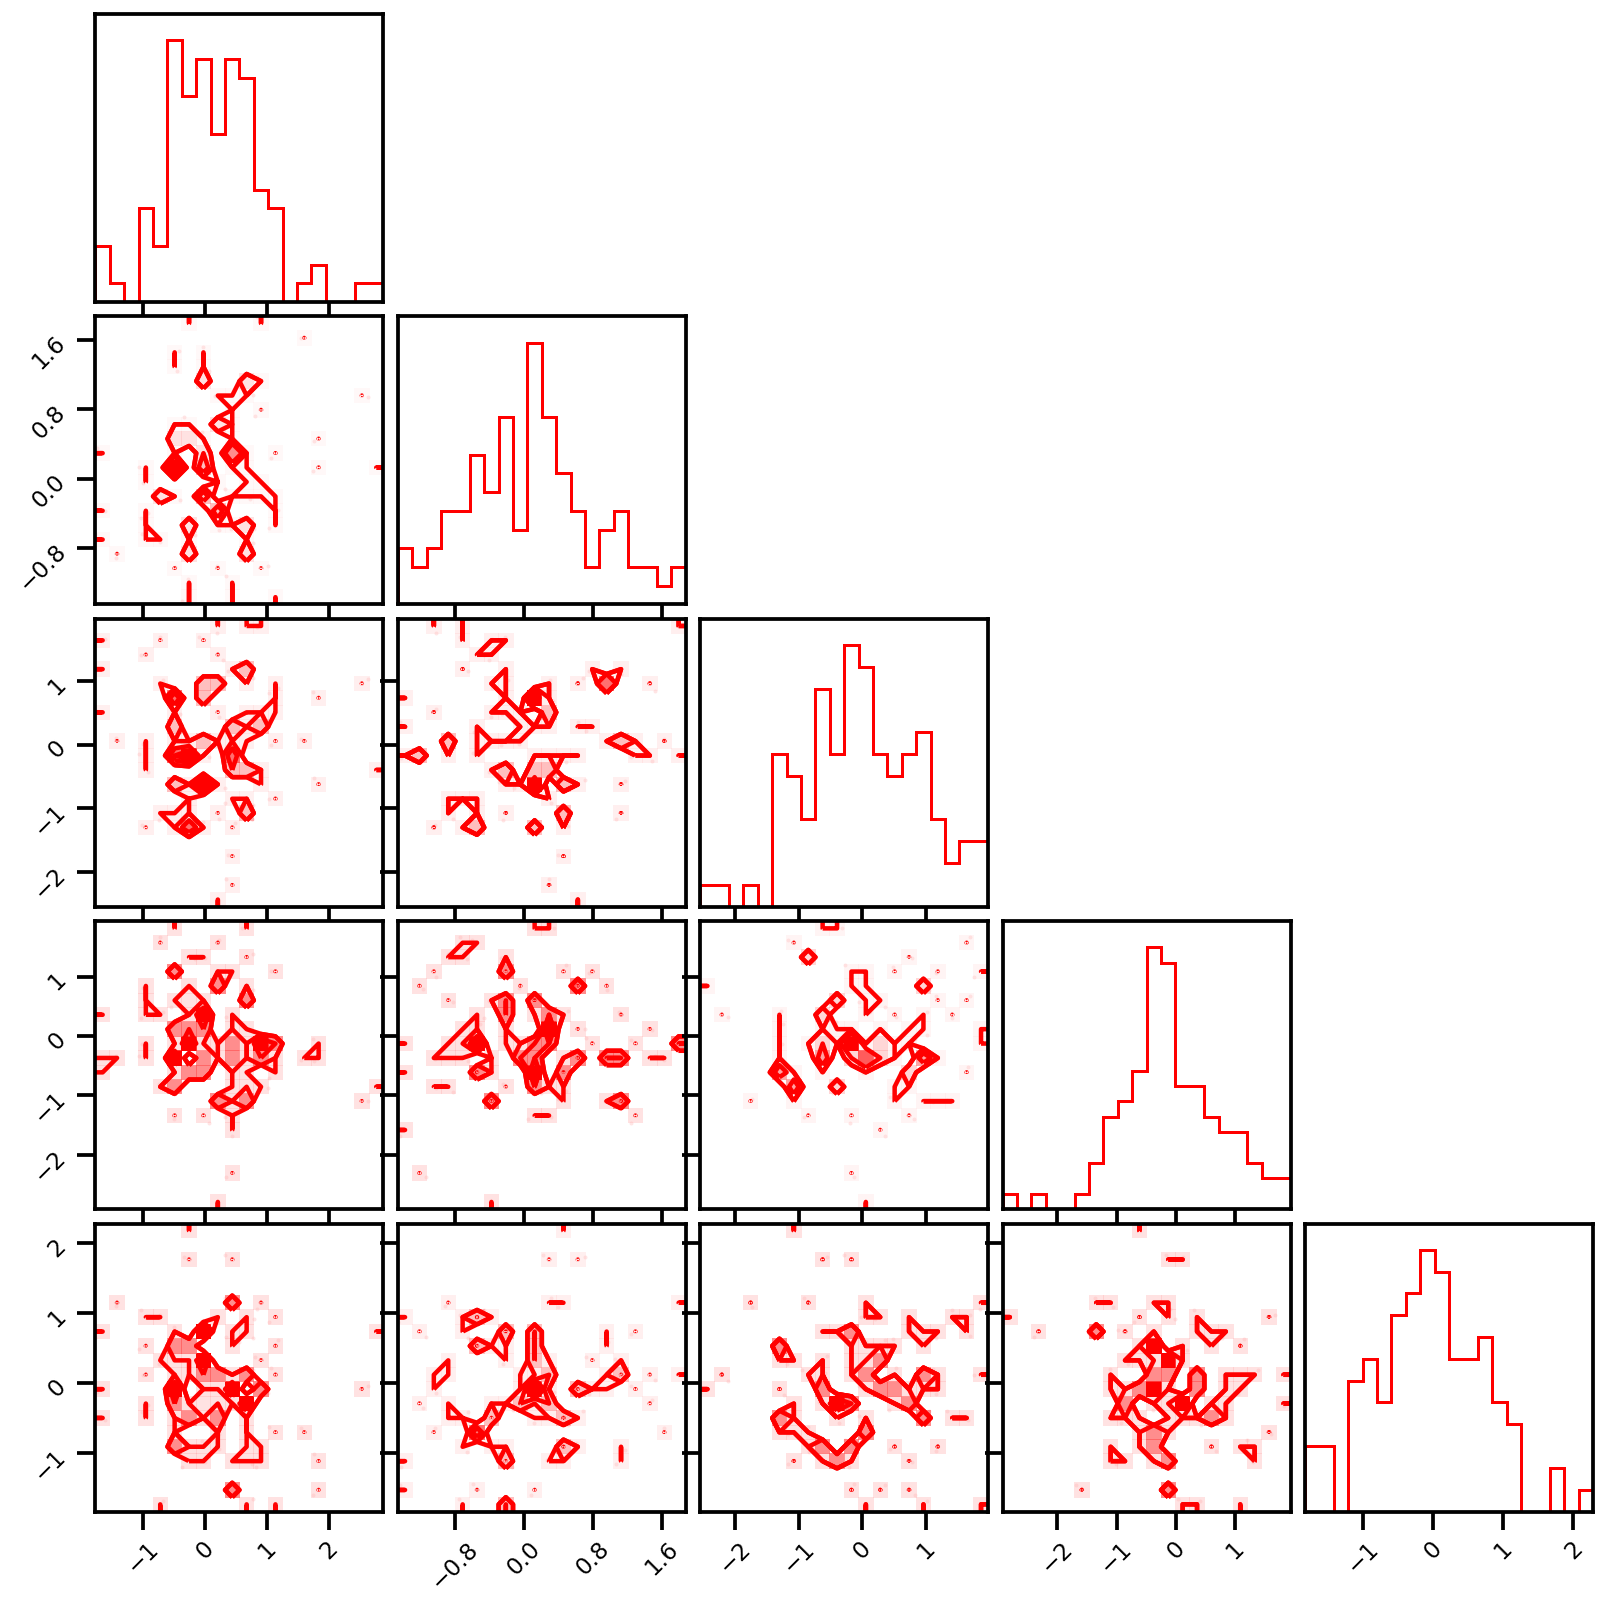

In [29]:
fig = corner.corner(z.detach().numpy()[:, :5], hist_factor=2, color="red")

#### Inverse Transform

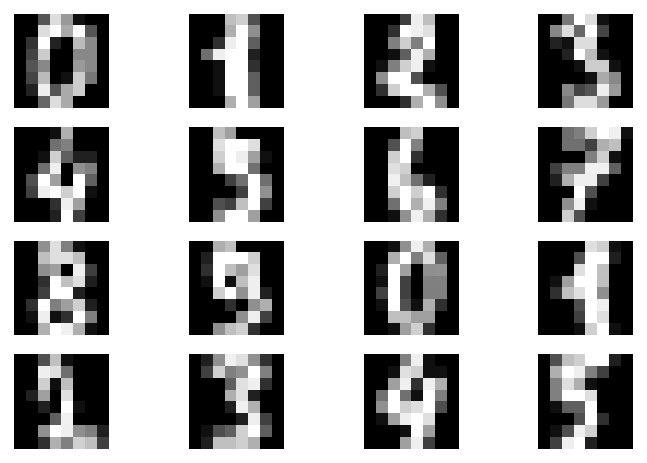

In [31]:
x_ori, _ = learn.model(z, rev=True)

plot_digits(x_ori.detach().numpy(), 4, 4)

2021-06-27 20:53:32,156:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,180:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,213:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,257:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,290:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,312:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,335:WARNING:Too few points to create valid contours
2021-06-27 20:53:32,358:WARNING:Too few points to create valid contours


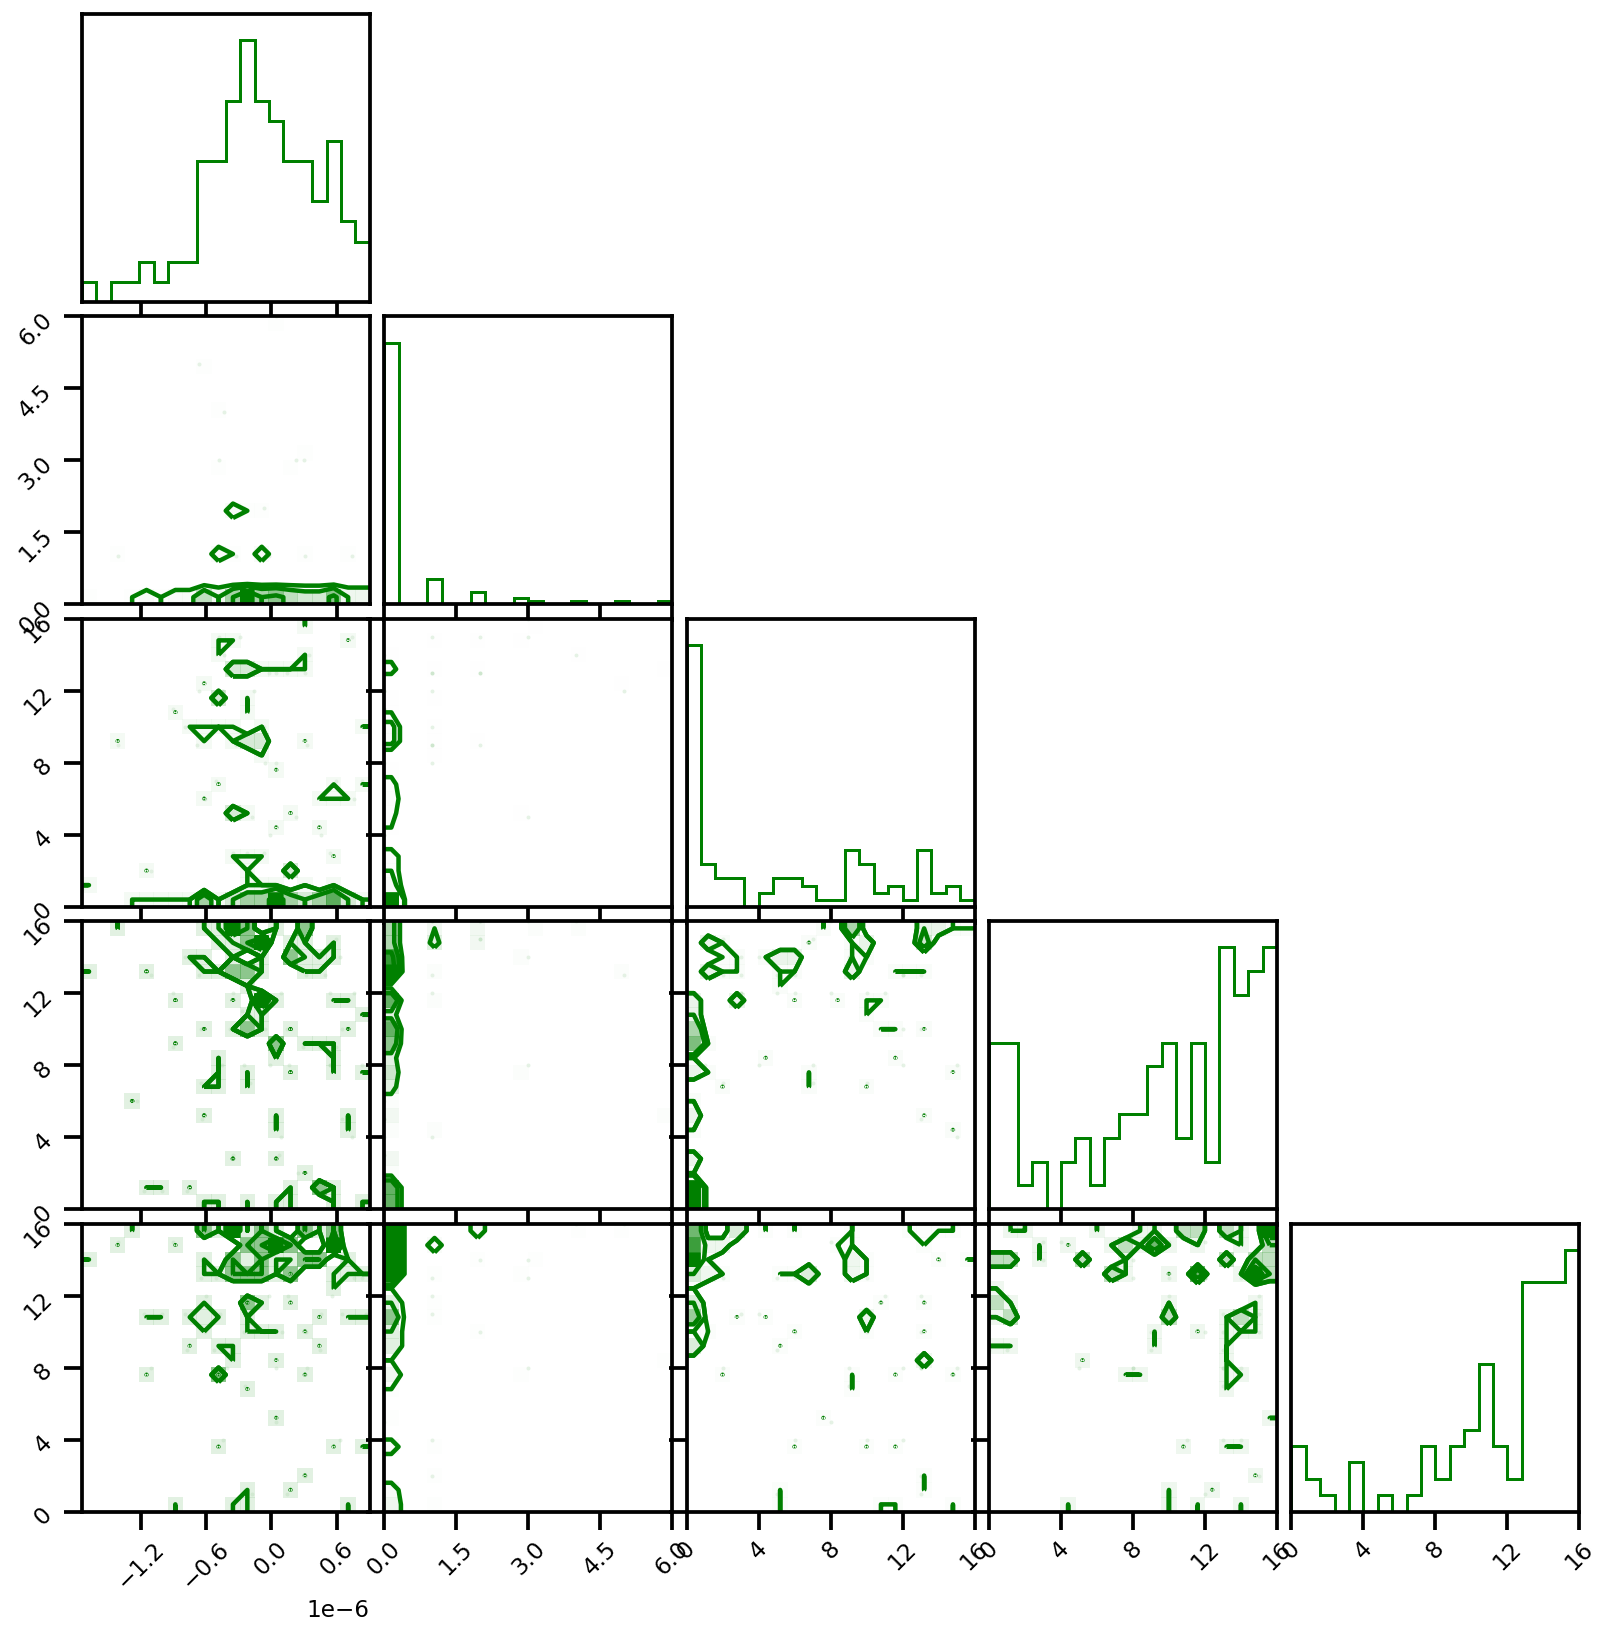

In [33]:
fig = corner.corner(x_ori.detach().numpy()[:, :5], hist_factor=2, color="green")

#### Sampling

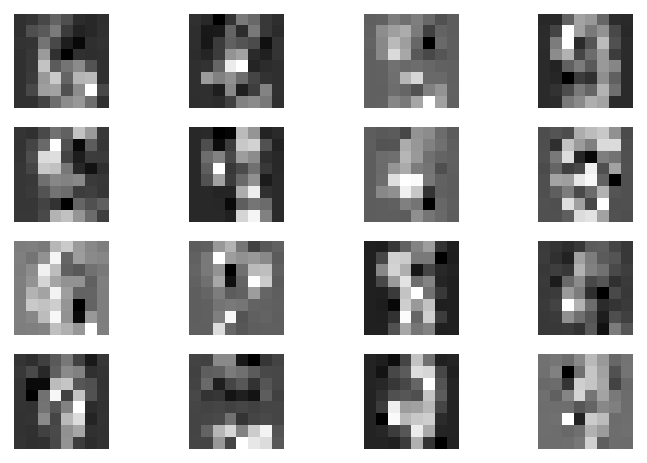

In [35]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 100
z = torch.randn(n_samples, N_DIM)
samples, _ = learn.model(z, rev=True)

plot_digits(samples.detach().numpy(), 4, 4)

In [ ]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")